# Simulating Excitatory Postsynaptic Potential (EPSP)

## Introduction

In this tutorial, we will learn how to simulate an excitatory postsynaptic potential (EPSP) using `bluecellulab`. In neuroscience, an excitatory postsynaptic potential (EPSP) is a type of postsynaptic potential that increases the likelihood of the postsynaptic neuron initiating an action potential.

In this tutorial, we will use a hippocampal cell to simulate an EPSP by introducing a current pulse into the dendrite. Subsequently, we will capture the voltage changes at the soma. Our demonstration will focus on determining the EPSP ratio between the dendrite and soma, as well as assessing the PSP delay between these two regions.

### Compiling the mechanisms

Before loading the cell, the cell mechanisms need to be compiled and provided. With NEURON installed, simply run the following command for the compilation.

**Note**: This time we are loading a hippocampal cell model, which has a different set of mechanisms than the cortical cell model.


In [1]:
!nrnivmodl hippocampus_mechanisms

/home/tuncel/git-repos/BlueCelluLab/examples/4-epsp
Mod files: "hippocampus_mechanisms/hippocampus_mechanisms/cacumm.mod" "hippocampus_mechanisms/hippocampus_mechanisms/cagk.mod" "hippocampus_mechanisms/hippocampus_mechanisms/cal2.mod" "hippocampus_mechanisms/hippocampus_mechanisms/can2.mod" "hippocampus_mechanisms/hippocampus_mechanisms/cat.mod" "hippocampus_mechanisms/hippocampus_mechanisms/h.mod" "hippocampus_mechanisms/hippocampus_mechanisms/kadist.mod" "hippocampus_mechanisms/hippocampus_mechanisms/kaprox.mod" "hippocampus_mechanisms/hippocampus_mechanisms/kca.mod" "hippocampus_mechanisms/hippocampus_mechanisms/kdb.mod" "hippocampus_mechanisms/hippocampus_mechanisms/kdrbca1.mod" "hippocampus_mechanisms/hippocampus_mechanisms/kmb.mod" "hippocampus_mechanisms/hippocampus_mechanisms/na3n.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Let's dive into the code:

### Importing Required Libraries

We first import the necessary libraries and modules.

In [2]:
from pathlib import Path

from bluecellulab import Cell, neuron
from bluecellulab.simulation import Simulation
from bluecellulab.simulation.neuron_globals import set_temperature

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")

### Setting Up the Model

We begin by defining the paths for our `hoc` and `morphology` files. The `hoc` file provides a high-level description of our cell's properties and geometry, while the `morphology` file gives details about the cell's physical structure.

Upon specifying these paths, we instantiate our hippocampal cell model using `bluecellulab`'s `Cell` class, leveraging the `bluepyopt` template format. 

To prepare our simulation, we create a `Simulation` object and add our cell model to it. Finally, for the purpose of this tutorial, we specifically choose a dendritic section (the sixth one in this case) using `cell.cell.getCell().dend[5]` to which we will later introduce the current pulse to simulate the EPSP.

In [3]:
base_dir = Path(".")

# Define the hoc and morphology files
hoc_file = base_dir / "hoc" / "cell_seed2_0.hoc"
morph_file = base_dir / "morphology" / "011017HP2.asc"

cell = Cell(hoc_file, morph_file, template_format="bluepyopt")
sim = Simulation()
sim.add_cell(cell)
a_section = cell.cell.getCell().dend[5]

### Preparing the Simulation

With our hippocampal cell model ready, we initiate a new `Simulation` using `bluecellulab`. After initializing the simulation, we add our previously defined cell to it.

To capture the dynamics of the EPSP, we set up a voltage recording on our targeted dendritic section, specifically at the middle of the section (0.5 fractional length). This will allow us to monitor how the voltage changes in this dendrite once the current pulse is introduced.

In [4]:
cell.add_voltage_recording(a_section, 0.5)

### Setting Up the Synapse and Current Recording

To simulate the EPSP, we introduce an alpha synapse on our targeted dendritic section. Here's a brief overview of the parameters we define:

- `onset`: The time (in milliseconds) when the synapse begins to have an effect
- `tau`: The time constant of the synapse, determining how fast the synapse will act
- `gmax`: The maximum conductance of the synapse
- `e`: The reversal potential of the synapse

Using the `add_alpha_synapse` function of our cell, we create our synapse on the chosen dendritic section.

To further investigate the impact of this synapse, we set up a recording of the current associated with it. This is achieved by creating a `Vector` object from NEURON's `h` module and instructing it to record the current (`_ref_i`) flowing through our synapse.

**Note:** We've set an onset of 300 milliseconds for our alpha synapse. This means we wanted to have 300ms of onset to wait until the cells stabilize before we inject the alpha synapse. Such an onset is useful to ensure that the cell is at a steady state before introducing any perturbations.

In [5]:
onset = 300.0
tau = 10.0
gmax = 0.0001
e = 0.0
synapse = cell.add_alpha_synapse(onset, tau, gmax, e, section=a_section)

current_vector = neuron.h.Vector()
_ = current_vector.record(synapse._ref_i)

### Executing the Simulation

With the neuron model and synapse set up, we're now ready to run our simulation. The `sim.run` function initiates the simulation with the following parameters:

- The simulation will run for `450` milliseconds
- `cvode` is set to `False`, implying we're not using the variable time step solver in this simulation
- `v_init` sets the initial membrane potential of our cell model
- `dt` is the time step of the simulation
- `celsius` determines the temperature at which the simulation runs 

Upon executing this function, the simulation will process the effects of our previously defined alpha synapse on the targeted dendritic section, and record the associated voltage and current changes.

In [6]:
duration = 450
dt = 0.1
set_temperature(34)
sim.run(duration, cvode=False, v_init=-70, dt=dt)

### Synaptic Current Visualization

Below, we're plotting the input synaptic current against time. The x-axis represents time (in milliseconds) while the y-axis shows the synaptic current's magnitude (in nanoamperes). 

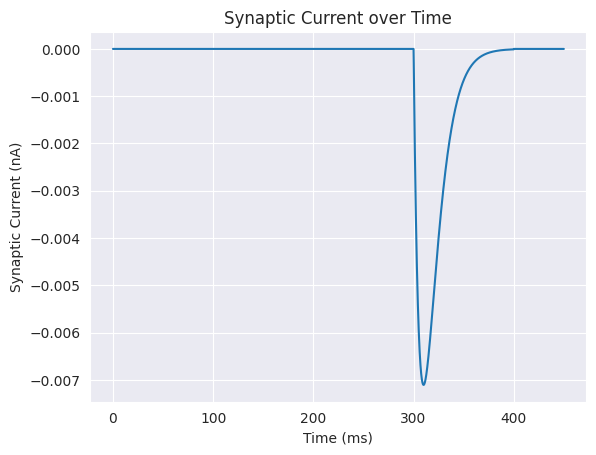

In [7]:
time = cell.get_time()

# Plotting the data
plt.plot(time, current_vector)

# Adding labels and title
plt.xlabel('Time (ms)')                 # X-axis label
plt.ylabel('Synaptic Current (nA)')     # Y-axis label
plt.title('Synaptic Current over Time') # Title of the plot

# Display the plot
plt.show()


The distance from the dendritic section to the soma is informative for understanding EPSPs, as there is a correlation between the two.

In [8]:
distance_to_soma = neuron.h.distance(cell.soma(0.5), a_section(0.5))
print(f"The distance to the soma is {distance_to_soma:.2f} μm.")

The distance to the soma is 177.86 μm.


### Voltage Response Analysis

Here, we're computing the following:

1. Compute the delay between the peak EPSPs of the dendrite and soma.
2. Determine the ratio of the dendritic to somatic EPSP amplitude, showcasing the attenuation or amplification as the signal moves towards the soma.

We are starting extracting the features at the onset of the stimulus, and ending the extraction at the end of the stimulus.

In [9]:
voltage = cell.get_voltage_recording(a_section, 0.5)
soma_voltage = cell.get_soma_voltage()

voltage_base_offset = 100
voltage_base_start_index = int(voltage_base_offset / dt)
protocol_start_index = int(onset / dt)
protocol_end_index = int((duration) / dt)  # extending till end of simulation

dendrite_voltage_base = np.median(voltage[voltage_base_start_index:protocol_start_index])
soma_voltage_base = np.median(soma_voltage[voltage_base_start_index:protocol_start_index])



dendrite_max_epsp = max(voltage[protocol_start_index:protocol_end_index])
soma_max_epsp = max(soma_voltage[protocol_start_index:protocol_end_index])
dendrite_psp_amplitude = dendrite_max_epsp - dendrite_voltage_base
soma_psp_amplitude = soma_max_epsp - soma_voltage_base

dendrite_max_epsp_index = np.argmax(voltage[protocol_start_index:protocol_end_index]) + protocol_start_index
soma_max_epsp_index = np.argmax(soma_voltage[protocol_start_index:protocol_end_index]) + protocol_start_index

psp_amplitude_ratio = dendrite_psp_amplitude / soma_psp_amplitude
delay = (soma_max_epsp_index - dendrite_max_epsp_index) * dt

print(f"Dendritic to Somatic EPSP Amplitude Ratio: {psp_amplitude_ratio:.2f}")
print(f"Delay Between Dendritic and Somatic EPSP Peaks: {delay:.2f} ms")

Dendritic to Somatic EPSP Amplitude Ratio: 3.24
Delay Between Dendritic and Somatic EPSP Peaks: 7.20 ms


### Displaying the results

The plot below shows the voltage over time for both the dendritic section (`a_section`) and the soma. The dashed lines represent baseline voltages for each region, while the red markers pinpoint the peak excitatory postsynaptic potentials (EPSPs) of the dendrite and soma. Annotations on the graph highlight the delay between dendritic and somatic EPSP peaks, the ratio of their amplitudes, and the distance of the dendritic section to the soma.

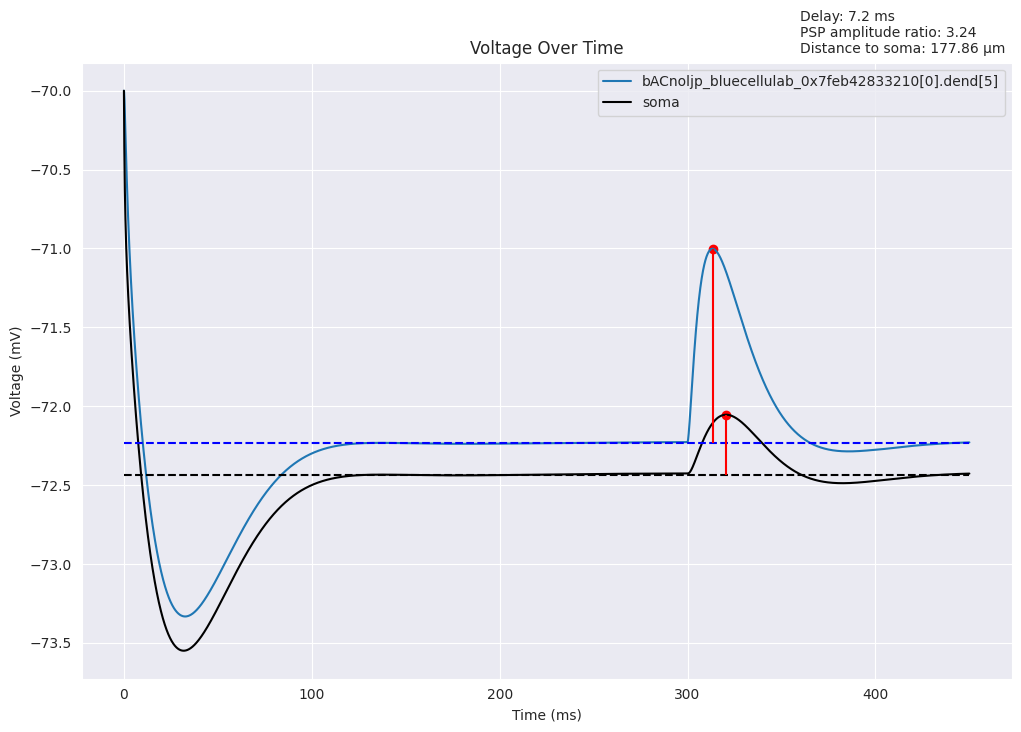

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(time, voltage, label=a_section.name())
plt.plot(time, soma_voltage, 'k', label='soma')

# annotate base voltages
plt.hlines([dendrite_voltage_base, soma_voltage_base], xmin=min(time), xmax=max(time), linestyles='dashed', colors=['blue', 'black'])

# annotate max epsp
plt.scatter([dendrite_max_epsp_index * dt, soma_max_epsp_index * dt], [dendrite_max_epsp, soma_max_epsp], color='red')
plt.vlines([dendrite_max_epsp_index * dt, soma_max_epsp_index * dt], ymin=[dendrite_voltage_base, soma_voltage_base], ymax=[dendrite_max_epsp, soma_max_epsp], colors='red')

plt.title('Voltage Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.legend()
plt.text(duration - 90, min(voltage) + 3.55, 
         f'Delay: {delay} ms\n'
         f'PSP amplitude ratio: {psp_amplitude_ratio:.2f}\n'
         f'Distance to soma: {distance_to_soma:.2f} μm',
         verticalalignment='bottom')

plt.show()

And there you have it! We've looked at how to simulate and study EPSPs in a neuron. We hope this guide helps you in your future work!